#LOADING LIBRARIES

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

#LOADING DATASET

In [ ]:
# downloading the images

!wget https://challengedata.ens.fr/media/public/train-images.zip
!wget https://challengedata.ens.fr/media/public/test-images.zip
!wget https://challengedata.ens.fr/media/public/label_Hnl61pT.csv -O y_train.csv

--2025-02-15 10:12:44--  https://challengedata.ens.fr/media/public/train-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52391647 (50M) [application/zip]
Saving to: ‘train-images.zip’

train-images.zip    100%[===================>]  49.96M  88.3MB/s    in 0.6s    

2025-02-15 10:12:45 (88.3 MB/s) - ‘train-images.zip’ saved [52391647/52391647]

--2025-02-15 10:12:45--  https://challengedata.ens.fr/media/public/test-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12803342 (12M) [application/zip]
Saving to: ‘test-images.zip’

test-images.zip     100%[===================>]  12.21M  69.1MB/s    in 0.2s    

2025-02-15 10:12:45 (69.1 

In [3]:
!unzip train-images.zip
!unzip test-images.zip

Archive:  train-images.zip
   creating: train-images/
  inflating: train-images/348.png    
  inflating: train-images/1804.png   
 extracting: train-images/1810.png   
 extracting: train-images/1186.png   
 extracting: train-images/412.png    
 extracting: train-images/374.png    
  inflating: train-images/1838.png   
 extracting: train-images/360.png    
 extracting: train-images/406.png    
  inflating: train-images/1192.png   
 extracting: train-images/1179.png   
 extracting: train-images/1145.png   
 extracting: train-images/1623.png   
 extracting: train-images/1637.png   
 extracting: train-images/1151.png   
 extracting: train-images/638.png    
  inflating: train-images/176.png    
 extracting: train-images/88.png     
 extracting: train-images/610.png    
 extracting: train-images/1384.png   
 extracting: train-images/1390.png   
 extracting: train-images/604.png    
  inflating: train-images/162.png    
 extracting: train-images/189.png    
 extracting: train-images/837.png 

In [4]:
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((256,256)) == 0, (seg.reshape((256,256))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")
    plt.show()

In [43]:
# Read the data and keep first 800 rows
labels = pd.read_csv('y_train.csv', index_col=0).T.iloc[:800]

# Create a new DataFrame with unique values and their counts for each row
result = labels.apply(
    lambda row: pd.Series({
        'num_unique': len(row.unique())
    }),
    axis=1
)

condition = result['num_unique'].apply(lambda x: x > 1)
labels_train = labels[condition]
# Alternative en une ligne
labeled_indices_array = np.where(condition)[0]

Our dataset images shape is torch.Size([759, 1, 256, 256])
Our dataset labels shape is torch.Size([759, 256, 256])


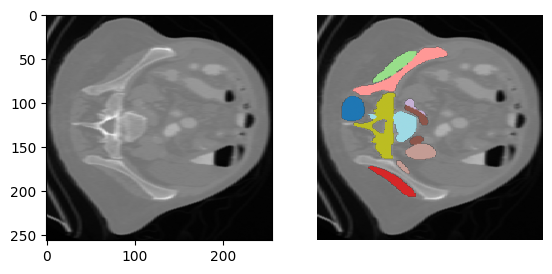

In [44]:
data_dir = Path("./")
data_train = load_dataset(data_dir / "train-images")
data_test = load_dataset(data_dir / "test-images")

## PREPROCESSING
## MIN MAX NORMALIZATION
# data_train = (data_train - np.min(data_train)) / (np.max(data_train) - np.min(data_train))
# data_test = (data_test - np.min(data_test)) / (np.max(data_test) - np.min(data_test))

## STANDARDIZATION
mean, std = data_train.mean(), data_train.std()
data_train = (data_train - mean) / (std + 1e-8)

mean, std = data_test.mean(), data_test.std()
data_test = (data_test - mean) / (std + 1e-8)


data_train_labeled = torch.from_numpy(data_train[labeled_indices_array]).type(torch.float32).reshape((-1, 1, 256,256))
data_test = torch.from_numpy(data_test).type(torch.float32).reshape((-1, 1, 256,256))
labels_train = torch.from_numpy(labels_train.to_numpy()).reshape((-1, 256,256))

print(f"Our dataset images shape is {data_train_labeled.shape}")
print(f"Our dataset labels shape is {labels_train.shape}")
plot_slice_seg(data_train_labeled[5].squeeze(), labels_train[5].squeeze())

In [45]:
## Split for train and test data
X_train, X_valid, y_train, y_valid = train_test_split(data_train_labeled, labels_train, test_size=0.02, random_state=0)
assert len(X_train) == len(y_train)
assert len(X_valid) == len(y_valid)
print(f"Number of training images {len(X_train)}")
print(f"Number of validation images {len(X_valid)}")

Number of training images 743
Number of validation images 16


In [46]:
#construction the data loaders
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=1, shuffle=True)
valid_loader = DataLoader(list(zip(X_valid, y_valid)), batch_size=1, shuffle=False)

dir_checkpoint = Path('./checkpoints/')

#UNET CLASS

In [47]:
import torch
import torch.nn as nn
import numpy as np

# PINGU PINGU PINGU!!!! O Macron é um bosta

class conv_block(nn.Module) :
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x) :
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module) :
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = conv_block(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2, 2))

    def forward (self, x) :
        x = self.conv(x)
        p = self.pool(x)
        return x,p

class decoder_block(nn.Module) :
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = conv_block(out_channels + out_channels, out_channels)

    def forward(self, x, skip) :
        x = self.pool(x)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class UNET(nn.Module) :
    def __init__(self, in_channels, nb_classes):
        super().__init__()

        ## Encoder
        self.enc1 = encoder_block(in_channels, 64)
        self.enc2 = encoder_block(64, 128)
        self.enc3 = encoder_block(128, 256)
        self.enc4 = encoder_block(256, 512)
        #Bottelneck
        self.b = conv_block(512, 1024)

        ## Decoder
        self.dec1 = decoder_block(1024, 512)
        self.dec2 = decoder_block(512, 256)
        self.dec3 = decoder_block(256, 128)
        self.dec4 = decoder_block(128, 64)

        #Classifier
        self.classifier = nn.Conv2d(64, nb_classes, kernel_size=1)

    def forward(self, x) :
        x1, p1 = self.enc1(x)
        x2, p2 = self.enc2(p1)
        x3, p3 = self.enc3(p2)
        x4, p4 = self.enc4(p3)

        x = self.b(p4)

        y1 = self.dec1(x, x4)
        y2 = self.dec2(y1, x3)
        y3 = self.dec3(y2, x2)
        y4 = self.dec4(y3, x1)

        out = self.classifier(y4)

        return out

In [48]:
## Elementary function to test UNET

def dice_image(prediction, ground_truth):
    intersection = np.sum(prediction * ground_truth)
    if np.sum(prediction) == 0 and np.sum(ground_truth) == 0:
        return np.nan
    return 2 * intersection / (np.sum(prediction) + np.sum(ground_truth))


def dice_multiclass(prediction, ground_truth):
    dices = []
    for i in range(1, NUM_CLASSES + 1): # skip background
        dices.append(dice_image(prediction == i, ground_truth == i))
    return np.array(dices)

def dice_pandas(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the dice score for each sample in the dataset and then average it"""
    y_pred_df = y_pred_df.T
    y_true_df = y_true_df.T
    individual_dice = []
    for row_index in range(y_true_df.values.shape[0]):
        dices = dice_multiclass(y_true_df.values[row_index].ravel(), y_pred_df.values[row_index].ravel())
        individual_dice.append(dices)

    final = np.stack(individual_dice)
    # First, average over images for each class
    # Then, average over classes
    cls_dices = np.nanmean(final, axis=0)
    return float(np.nanmean(cls_dices))

In [49]:
def dice_loss(pred, target, smooth=1e-7):

    pred = torch.softmax(pred, dim=1)
    target_onehot = torch.nn.functional.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2)
    intersection = (pred * target_onehot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_onehot.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

In [ ]:
def train_unet(model, device, train_loader, valid_loader, labels_weights, nb_epochs, save_checkpoint=True) :

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    labels_weights = labels_weights.to(device)

    criterion = nn.CrossEntropyLoss(weight=labels_weights)
    model = model.to(device)

    for epoch in range(nb_epochs) :

        model.train()
        train_loss = 0

        for (image, mask) in train_loader :

            image = image.to(device=device)
            mask = mask.to(device=device)
            optimizer.zero_grad()
            output = model(image)
            loss_ce = criterion(output, mask)
            loss_dice = dice_loss(output, mask)
            loss = 0.8 * loss_dice + 0.2 * loss_ce
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # for name, param in model.named_parameters():
            #   if param.grad is not None and torch.isnan(param.grad).any():
            #       print(f"NaN gradient in {name}")
            #       return "Stooooop"

            optimizer.step()
            train_loss += loss.item()


        with torch.no_grad() :
            model.eval()
            test_loss = 0
            predictions = []
            true_masks = []

            for (image, mask) in valid_loader :
                true_masks.append(mask.cpu().numpy().squeeze())
                image = image.to(device=device)
                mask = mask.to(device=device)

                output = model(image)

                pred = torch.argmax(output, dim=1)
                predictions.append(pred.squeeze().cpu().numpy())

                loss_ce = criterion(output, mask)
                loss_dice = dice_loss(output, mask)
                loss = 0.8 * loss_dice + 0.2 * loss_ce

                test_loss += loss.item()

            predictions = pd.DataFrame(np.array(predictions).reshape((-1, 256*256)))
            valid = pd.DataFrame(np.array(true_masks).reshape((-1, 256*256)))

            score = dice_pandas(valid, predictions)

        print(f"Epoch : {epoch} \t Training Loss : {train_loss / len(train_loader):.3f} \t Test Loss : {test_loss / len(valid_loader):.3f} \t Score: {score:.3f}")

        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
            #print(f'Checkpoint {epoch} saved!')

#TRAINING

In [51]:
import json

# Weights for the cross entropy loss

file_name = "./annotated_labels.json"
with open(file_name, 'r') as file :
    data = json.load(file)

flattened_data = []
for i in data :
    flattened_data += i

labels, labels_count = np.unique(flattened_data, return_counts=True)
labels_weights = labels_count / np.sum(labels_count)

# adding the background
labels_weights = np.insert(labels_weights, 0, 0.0001)
class_weights = torch.from_numpy(labels_weights).type(torch.float32)

In [52]:
NUM_CLASSES = 55

model = UNET(in_channels=1, nb_classes=NUM_CLASSES)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")
train_unet(model, device, train_loader, valid_loader, class_weights, nb_epochs=15, save_checkpoint=True)

Device : cuda


<ipython-input-48-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 0 	 Training Loss : 1.376 	 Test Loss : 1.450 	 Score: 0.008


<ipython-input-48-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 1 	 Training Loss : 1.220 	 Test Loss : 1.482 	 Score: 0.014


<ipython-input-48-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 2 	 Training Loss : 1.133 	 Test Loss : 1.541 	 Score: 0.017


<ipython-input-48-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 3 	 Training Loss : 1.074 	 Test Loss : 1.480 	 Score: 0.025


<ipython-input-48-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 4 	 Training Loss : 1.026 	 Test Loss : 1.416 	 Score: 0.046


<ipython-input-48-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 5 	 Training Loss : 0.985 	 Test Loss : 1.591 	 Score: 0.030


<ipython-input-48-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 6 	 Training Loss : 0.956 	 Test Loss : 1.367 	 Score: 0.068


<ipython-input-48-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 7 	 Training Loss : 0.930 	 Test Loss : 1.408 	 Score: 0.067


<ipython-input-48-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 8 	 Training Loss : 0.909 	 Test Loss : 1.440 	 Score: 0.062


<ipython-input-48-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 9 	 Training Loss : 0.895 	 Test Loss : 1.415 	 Score: 0.080


<ipython-input-48-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 10 	 Training Loss : 0.876 	 Test Loss : 1.425 	 Score: 0.058


<ipython-input-48-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 11 	 Training Loss : 0.862 	 Test Loss : 1.440 	 Score: 0.056


<ipython-input-48-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 12 	 Training Loss : 0.858 	 Test Loss : 1.501 	 Score: 0.044


<ipython-input-48-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 13 	 Training Loss : 0.844 	 Test Loss : 1.381 	 Score: 0.041


<ipython-input-48-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 14 	 Training Loss : 0.834 	 Test Loss : 1.370 	 Score: 0.056


In [53]:
test_model = UNET(in_channels=1, nb_classes=NUM_CLASSES)
test_model.load_state_dict(torch.load(str(dir_checkpoint / 'checkpoint_epoch9.pth'), weights_only=True))
test_model.eval()

UNET(
  (enc1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()

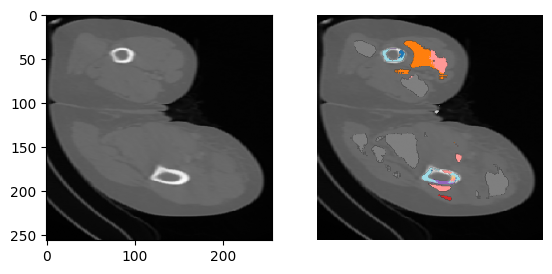

In [54]:
# VISUAL TESTING

image_test = data_test[4]
label_test = test_model(image_test.unsqueeze(0))
pred_test = torch.argmax(label_test, dim=1)
plot_slice_seg(image_test.squeeze(), pred_test.squeeze())